In [447]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get Data

In [448]:
train = pd.read_csv('train.csv', header=False)
test = pd.read_csv('test.csv', header=False)

#Concatenate train and test samples ( test started with 892 Id )
full = pd.concat([train.drop('Survived', 1), test])

In [530]:
full[:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Mother,Child,Deck
0,1,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,2,7,0,0,0,5
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,0,8,0,0,0,2
2,3,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,2,4,0,0,0,4
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,2,8,0,0,0,2
4,5,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,2,7,0,0,0,4


### Prepare data

In [450]:
# Another one number of Nulls in each column
full.isnull().sum(axis=0)

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [451]:
# Fill empty Embarked values

embarked_maxs = full.groupby('Embarked').count()
max_emb = embarked_maxs.loc[embarked_maxs.PassengerId == embarked_maxs.PassengerId.max(), 'PassengerId'].argmax()
print max_emb

full.Embarked = full.Embarked.fillna(max_emb)

S


#### 1. Feature Engineering

In [548]:
import re
import math

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def get_deck(name):
    if not isinstance(name, str):
        return np.nan
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search('([A-Za-z]+)', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return np.nan

def get_cabin_pos(name):
    if not isinstance(name, str):
        return np.nan
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search('([0-9]+)', name)
    # If the title exists, extract and return it.
    if title_search:
        return int(title_search.group(1))
    return np.nan

In [453]:
# Get all the titles and print how often each one occurs.
titles = full["Name"].apply(get_title)

full["Title"] = titles
full.loc[ (full.Title == "Capt") | (full.Title == "Don") | (full.Title == "Major") | (full.Title == "Sir"), "Title" ] = "Sir"
full.loc[ (full.Title == "Dona") | (full.Title == "Lady") | (full.Title == "Countess") | (full.Title == "Jonkheer"), "Title" ] = "Lady"

full.Title.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Dr          8
Rev         8
Sir         5
Col         4
Lady        4
Ms          2
Mlle        2
Mme         1
dtype: int64

In [526]:
# Generate FamilySize as a sum of parents, children and siblings

full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full.loc[full.FamilySize <= 2, 'FamilySize'] = 0

In [455]:
# Add feature 'is Mother'
full['Mother'] = 0
full.loc[ (full.Sex == 'female') & (full.Parch > 0) & (full.Age > 18) & (full.Title != 'Miss'), 'Mother' ] = 1

In [456]:
# Add feature 'is Child'

full['Child'] = 0
full.loc[ (full.Parch > 0) & (full.Age <= 18), 'Child' ] = 1

In [457]:
# Add feature 'Deck'
decks = full["Cabin"].apply(get_deck)
full["Deck"] = decks

In [556]:
# Get all numbers of a cabin and cluster them in 3 three groups
cabins = full["Cabin"].apply(get_cabin_pos)
full["CabinPos"] = cabins
full.CabinPos = full.CabinPos.fillna(-1)

#### 2. Fill (predict) Nulls

In [458]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for c in ['Embarked', 'Sex', 'Title']:
    full[c] = lbl_enc.fit_transform(full[c])

In [459]:
# Predict missing Fare values

from sklearn.tree import DecisionTreeRegressor
cols = ['Pclass', 'Title', 'Sex', 'SibSp', 'Parch']
clf = DecisionTreeRegressor(max_depth=5, max_features=0.5)
clf = clf.fit(full[cols].loc[full.Fare.notnull()], full.loc[full.Fare.notnull()].Fare)
full.loc[full.Fare.isnull(), 'Fare'] = clf.predict(full[cols].loc[full.Fare.isnull()])

In [460]:
# Predict missing Age values

from sklearn.tree import DecisionTreeRegressor
cols = ['Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'Fare']
clf = DecisionTreeRegressor(max_depth=5, max_features=0.5)
clf = clf.fit(full[cols].loc[full.Age.notnull()], full.loc[full.Age.notnull()].Age)
full.loc[full.Age.isnull(), 'Age'] = clf.predict(full[cols].loc[full.Age.isnull()])

In [461]:
# Predict missing Deck values

from sklearn.tree import DecisionTreeClassifier
cols = ['Pclass', 'Fare']
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(full[cols].loc[full.Deck.notnull()], full.loc[full.Deck.notnull()].Deck)
full.loc[full.Deck.isnull(), 'Deck'] = clf.predict(full[cols].loc[full.Deck.isnull()])

In [462]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for c in ['Deck']:
    full[c] = lbl_enc.fit_transform(full[c])
    
full[:3]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Mother,Child,Deck
0,1,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,2,7,2,0,0,5
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,0,8,2,0,0,2
2,3,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,2,4,1,0,0,4


#### 3. Split data

In [559]:
train_filled = full.loc[full.PassengerId < 892]
test_filled = full.loc[full.PassengerId >= 892]

In [561]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Mother', 'Child', 'Deck', 'FamilySize', 'CabinPos']

#### 4. Scale data

In [562]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_fit = scaler.fit_transform(train_filled[cols].values)
test_fit = scaler.transform(test_filled[cols].values)
train_fit[:3]

array([[ 0.82737724,  0.73769513, -0.56176141,  0.43279337, -0.47367361,
        -0.50244517,  0.58595414,  0.40951404, -0.24895491, -0.33312545,
         0.62712133, -0.46921611, -0.42449036],
       [-1.56610693, -1.35557354,  0.61860577,  0.43279337, -0.47367361,
         0.78684529, -1.9423032 ,  1.00088682, -0.24895491, -0.33312545,
        -1.47349936, -0.46921611,  2.73408399],
       [ 0.82737724, -1.35557354, -0.26666962, -0.4745452 , -0.47367361,
        -0.48885426,  0.58595414, -1.36460431, -0.24895491, -0.33312545,
        -0.07308557, -0.46921611, -0.42449036]])

## Try to evaluate score with different params of RF 

In [112]:
# Try to evaluate CV with RF Classifier

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import time

best_score = 0
best_params = {}

time1 = time.time()
for feature in [3, 4, 5, 6, 7, 8, 'sqrt', 'log2']:
    for crt in ['gini', 'entropy']:
            for depth in [2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100, 250]:
                clf = RandomForestClassifier(n_estimators=1250, criterion=crt, oob_score=True, max_depth=depth, max_features=feature)
                score = cross_val_score(clf, train_fit, train.Survived).mean()
                if (score > best_score):
                    best_score = score
                    best_params = {'n_estimators': 1250, 'criterion': crt, 'max_features': feature, 'max_depth': depth}
time2 = time.time()
print("time: " + str((time2 - time1) * 1000.0))
print("score: " + str(best_score))
print("best_params: " + str(best_params))

time: 530485.253811
score: 0.833894500561
best_params: {'n_estimators': 10, 'max_features': None, 'criterion': 'entropy', 'max_depth': 10}


## Train RF and predict values for Test

In [563]:
# Train our classifier with optimal parameters
from sklearn.ensemble import RandomForestClassifier

# Try 
# 20 7 7 entropy
# and
# 5 7 15 gini
# best (0.80383) == 1250 est, 5 depth, 4 features, 'gini', OOB

clf = RandomForestClassifier(
                n_estimators=1250, 
                criterion='gini', 
                oob_score=True, 
                max_depth=5, 
                max_features=4, 
                random_state=42,
                n_jobs=-1 )
clf.fit(train_fit, train.Survived)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=4, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1250, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

Feature ranking:


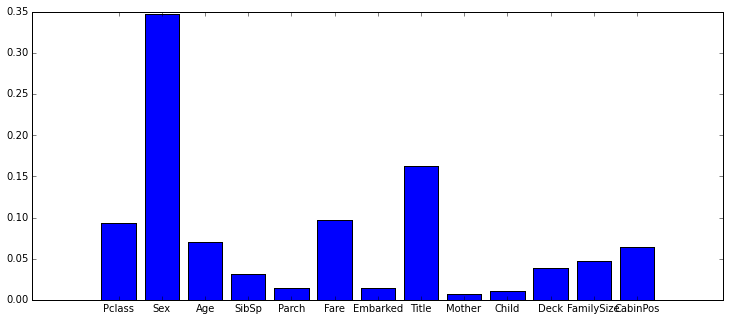

In [564]:
# Show feature importances
import pylab
import scipy

importances = clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

labels = [cols[i] for i in indices.tolist()]
x = scipy.array(indices)
y = scipy.array(importances[indices])
f = pylab.figure(figsize=(12,5))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels)
f.show()

In [565]:
# Make a prediction with RF
prediction = clf.predict(test_fit)
prediction[:50]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1])

In [518]:
# Collect output to csv
submit = pd.read_csv('test.csv')[['PassengerId']]
submit['Survived'] = prediction
submit[:5]

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [519]:
# Save it
submit.to_csv('submit.csv', index=False)